# XGBoost Model Development and Evaluation Pipeline

# End-to-end workflow for handling imbalanced data — from dataset loading and visualization to hyperparameter tuning, cross-validation, and balanced accuracy analysis using XGBoost.

# **Install additional visualization and dimensionality reduction libraries**

In [1]:
!pip install ptitprince
!pip install umap-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 44.9 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for ptitprince: filename=ptitprince-0.3.1-py3-none-any.whl size=16216 sha256=e3dfb22d38e63fe9a2ec1811aa619073a5ef0b26ce06ff590965839f073b2eb8
  Stored in directory: /root/.cache/pip/wheels/5d/79/49/b89a41fd3d8780ce2c21c7f2debe45f3c6b08d8aef400e3df1
Successfully built ptitprince


In [2]:
#Mount My Google Drive for Data Access
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import ptitprince as pt
from scipy.stats import chi2_contingency
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
import plotly.express as px
from scipy.stats import mannwhitneyu
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
import umap
from sklearn.manifold import TSNE
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split,StratifiedKFold, RandomizedSearchCV
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from scipy.stats import uniform, randint
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay,balanced_accuracy_score
from xgboost import plot_importance
from sklearn.model_selection import RepeatedStratifiedKFold, cross_val_score
import shap

Mounted at /content/gdrive


# **Loading the Dataset**

In [3]:
# Read the Dataset
df = pd.read_csv('/content/gdrive/MyDrive/XGBoost_task/sim_interview_dataset.csv', sep=',', header=None)

# Use the first row as column names and then drop the first row
df.columns = df.iloc[0]
df = df[1:].reset_index(drop=True)


In [4]:
# Create a copy of the DataFrame to analyse the categorical features
df_categorical_copy = df.copy()

In [5]:
# Encode categorical variables as numeric values:
# 'sex': M → 1, F → 0
df['sex'] = df['sex'].map({'M': 1, 'F': 0})

# 'location': Rural → 1, Urban → 2, Hospital → 3
df['location'] =df['location'].map({'Rural': 1, 'Urban': 2, 'Hospital': 3})

# **Basic descriptive statistics of features**

In [6]:
# Create a copy of the DataFrame to avoid modifying the original data
df_stat = df.copy()

# Ensure 'df_stat' is numeric
df_stat = df_stat.apply(pd.to_numeric, errors='coerce')

# Basic descriptive statistics with valid/missing counts
stats = pd.DataFrame({
    'Valid': df_stat.notna().sum(),
    'Missing': df_stat.isna().sum(),
    'Mean': df_stat.mean(),
    'Std Dev': df_stat.std(),
    'Min': df_stat.min(),
    'Max': df_stat.max()
})

# Optional: round for neatness
stats = stats.round(2)

# Display
print(stats)

                              Valid  Missing    Mean  Std Dev   Min    Max
0                                                                         
days_in_hospital              18989     1011   15.09     8.61   0.0   30.0
age                           19050      950   14.93     8.71   0.0   30.0
sex                           19015      985    0.49     0.50   0.0    1.0
previous_amr                  18967     1033    0.31     0.46   0.0    1.0
days_of_previous_antibiotics  18988     1012   14.94     8.67   0.0   30.0
last_blood_test               18962     1038    4.97     2.89   0.0   10.0
location                      19057      943    2.00     0.82   1.0    3.0
temperature                   19039      961   36.51     1.45  34.0   39.0
heart_rate                    18996     1004  104.98    26.04  60.0  150.0
resp_rate                     19045      955   19.06     6.35   8.0   30.0
sbp                           19016      984  120.01    23.12  80.0  160.0
outcome                  

In [7]:
# Create a cleaned DataFrame by dropping any rows that contain missing values, for PCA, t-SNE and UMAP visualization
df_clean = df.dropna()

# **Raincloud Plot Comparing the distribution of various features between outcome groups (0 and 1)**

/usr/local/lib/python3.12/dist-packages/ptitprince/PtitPrince.py:1070: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
/usr/local/lib/python3.12/dist-packages/ptitprince/PtitPrince.py:1070: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
/usr/local/lib/python3.12/dist-packages/ptitprince/PtitPrince.py:1070: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
/usr/local/lib/python3.12/dist-packages/ptitprince/PtitPrince.py:1070: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` va

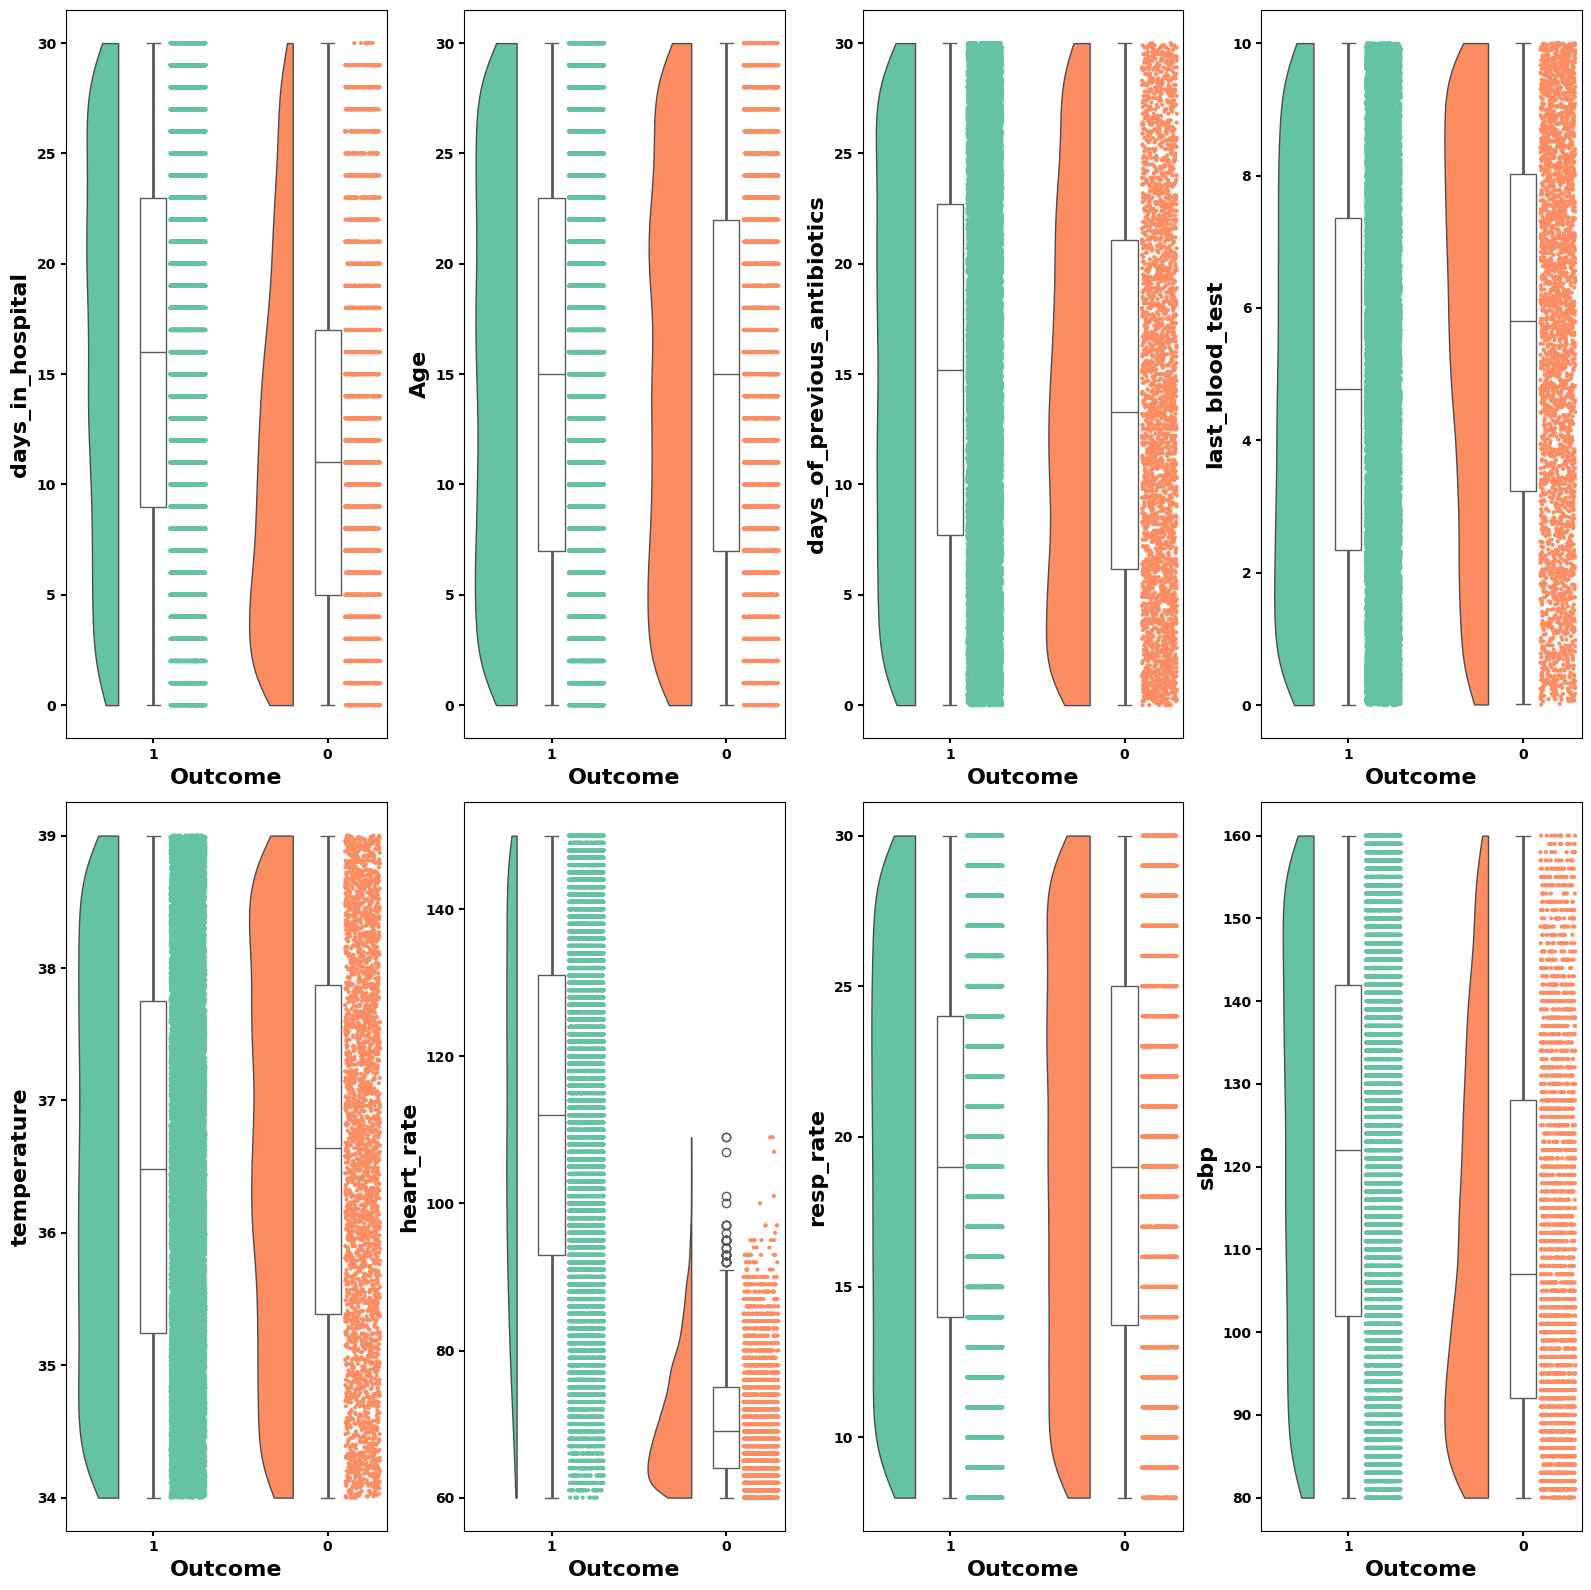

In [8]:
# Create a copy of the DataFrame to avoid modifying the original data
df_RPlot = df.copy()
# Ensure 'days_in_hospital' is numeric; non-numeric values are converted to NaN
df_RPlot['days_in_hospital'] = pd.to_numeric(df_RPlot['days_in_hospital'], errors='coerce')

# Create a 2x4 grid of subplots
fig, axes = plt.subplots(2, 4, figsize=(16, 16))  # 2 rows, 4 columns

# Plot in the first subplot [row 0, col 0]
ax = axes[0, 0]

# Generate a Raincloud plot to visualize the distribution of days_in_hospital by outcome
pt.RainCloud(
    x='outcome',
    y='days_in_hospital',
    data=df_RPlot,
    ax=axes[0, 0],     # Plot in the first subplot [row 0, col 0]
    palette="Set2",
    bw=.2,             # bandwidth (controls smoothness of the violin)
    width_viol=.5,     # width of the violin
    orient='v',        # vertical orientation
    move=0.2           # separates distributions slightly
)

# Add title and axis labels for clarity
ax.set_xlabel('Outcome', fontsize=16, fontweight='bold')
ax.set_ylabel('days_in_hospital', fontsize=16, fontweight='bold')

plt.tight_layout()

# Display the plot
#plt.show()

# Ensure 'age' is numeric; non-numeric values are converted to NaN
df_RPlot['age'] = pd.to_numeric(df_RPlot['age'], errors='coerce')

# Generate a Raincloud plot to visualize the distribution of age use by outcome
pt.RainCloud(
    x='outcome',
    y='age',
    data=df_RPlot,
    ax=axes[0, 1],     # Plot in the first subplot [row 0, col 1]
    palette="Set2",
    bw=.2,             # bandwidth (controls smoothness of the violin)
    width_viol=.5,     # width of the violin
    orient='v',        # vertical orientation
    move=0.2           # separates distributions slightly
)

ax = axes[0, 1]
# Add title and axis labels for clarity
ax.set_xlabel('Outcome', fontsize=16, fontweight='bold')
ax.set_ylabel('Age', fontsize=16, fontweight='bold')

plt.tight_layout()


# Ensure 'days_of_previous_antibiotics' is numeric; non-numeric values are converted to NaN
df_RPlot['days_of_previous_antibiotics'] = pd.to_numeric(df_RPlot['days_of_previous_antibiotics'], errors='coerce')

# Generate a Raincloud plot to visualize the distribution of days_of_previous_antibiotics use by outcome
pt.RainCloud(
    x='outcome',
    y='days_of_previous_antibiotics',
    data=df_RPlot,
    ax=axes[0, 2],     # Plot in the first subplot [row 0, col 2]
    palette="Set2",
    bw=.2,             # bandwidth (controls smoothness of the violin)
    width_viol=.5,     # width of the violin
    orient='v',        # vertical orientation
    move=0.2           # separates distributions slightly
)
ax=axes[0, 2]
# Add title and axis labels for clarity
ax.set_xlabel('Outcome', fontsize=16, fontweight='bold')
ax.set_ylabel('days_of_previous_antibiotics', fontsize=16, fontweight='bold')

plt.tight_layout()

# Ensure 'last_blood_test' is numeric; non-numeric values are converted to NaN
df_RPlot['last_blood_test'] = pd.to_numeric(df_RPlot['last_blood_test'], errors='coerce')

# Generate a Raincloud plot to visualize the distribution of days_of_previous_antibiotics use by outcome
pt.RainCloud(
    x='outcome',
    y='last_blood_test',
    data=df_RPlot,
    ax=axes[0, 3],     # Plot in the first subplot [row 0, col 3]
    palette="Set2",
    bw=.2,             # bandwidth (controls smoothness of the violin)
    width_viol=.5,     # width of the violin
    orient='v',        # vertical orientation
    move=0.2           # separates distributions slightly
)
ax=axes[0, 3]
# Add title and axis labels for clarity
ax.set_xlabel('Outcome', fontsize=16, fontweight='bold')
ax.set_ylabel('last_blood_test', fontsize=16, fontweight='bold')

plt.tight_layout()

# Ensure 'temperature' is numeric; non-numeric values are converted to NaN
df_RPlot['temperature'] = pd.to_numeric(df_RPlot['temperature'], errors='coerce')

# Generate a Raincloud plot to visualize the distribution of days_of_previous_antibiotics use by outcome
pt.RainCloud(
    x='outcome',
    y='temperature',
    data=df_RPlot,
    ax=axes[1, 0],     # Plot in the first subplot [row 0, col 3]
    palette="Set2",
    bw=.2,             # bandwidth (controls smoothness of the violin)
    width_viol=.5,     # width of the violin
    orient='v',        # vertical orientation
    move=0.2           # separates distributions slightly
)
ax=axes[1,0]
# Add title and axis labels for clarity
ax.set_xlabel('Outcome', fontsize=16, fontweight='bold')
ax.set_ylabel('temperature', fontsize=16, fontweight='bold')

plt.tight_layout()

# Ensure 'heart_rate' is numeric; non-numeric values are converted to NaN
df_RPlot['heart_rate'] = pd.to_numeric(df_RPlot['heart_rate'], errors='coerce')

# Generate a Raincloud plot to visualize the distribution of days_of_previous_antibiotics use by outcome
pt.RainCloud(
    x='outcome',
    y='heart_rate',
    data=df_RPlot,
    ax=axes[1, 1],     # Plot in the first subplot [row 0, col 3]
    palette="Set2",
    bw=.2,             # bandwidth (controls smoothness of the violin)
    width_viol=.5,     # width of the violin
    orient='v',        # vertical orientation
    move=0.2           # separates distributions slightly
)
ax=axes[1,1]
# Add title and axis labels for clarity
ax.set_xlabel('Outcome', fontsize=16, fontweight='bold')
ax.set_ylabel('heart_rate', fontsize=16, fontweight='bold')

plt.tight_layout()


# Ensure 'resp_rate' is numeric; non-numeric values are converted to NaN
df_RPlot['resp_rate'] = pd.to_numeric(df_RPlot['resp_rate'], errors='coerce')

# Generate a Raincloud plot to visualize the distribution of days_of_previous_antibiotics use by outcome
pt.RainCloud(
    x='outcome',
    y='resp_rate',
    data=df_RPlot,
    ax=axes[1, 2],     # Plot in the first subplot [row 0, col 3]
    palette="Set2",
    bw=.2,             # bandwidth (controls smoothness of the violin)
    width_viol=.5,     # width of the violin
    orient='v',        # vertical orientation
    move=0.2           # separates distributions slightly
)
ax=axes[1,2]
# Add title and axis labels for clarity
ax.set_xlabel('Outcome', fontsize=16, fontweight='bold')
ax.set_ylabel('resp_rate', fontsize=16, fontweight='bold')

plt.tight_layout()


# Ensure 'sbp' is numeric; non-numeric values are converted to NaN
df_RPlot['sbp'] = pd.to_numeric(df_RPlot['sbp'], errors='coerce')

# Generate a Raincloud plot to visualize the distribution of days_of_previous_antibiotics use by outcome
pt.RainCloud(
    x='outcome',
    y='sbp',
    data=df_RPlot,
    ax=axes[1, 3],     # Plot in the first subplot [row 0, col 3]
    palette="Set2",
    bw=.2,             # bandwidth (controls smoothness of the violin)
    width_viol=.5,     # width of the violin
    orient='v',        # vertical orientation
    move=0.2           # separates distributions slightly
)
ax=axes[1,3]
# Add title and axis labels for clarity
ax.set_xlabel('Outcome', fontsize=16, fontweight='bold')
ax.set_ylabel('sbp', fontsize=16, fontweight='bold')

plt.tight_layout()


# Make tick labels bold for ALL subplots
for ax in axes.flat:
    ax.tick_params(axis='both', labelsize=10, width=1.5)
    for tick in ax.get_xticklabels() + ax.get_yticklabels():
        tick.set_fontweight('bold')


# **Bar Chart Comparing the distribution of various categorical features between outcome groups (0 and 1)**

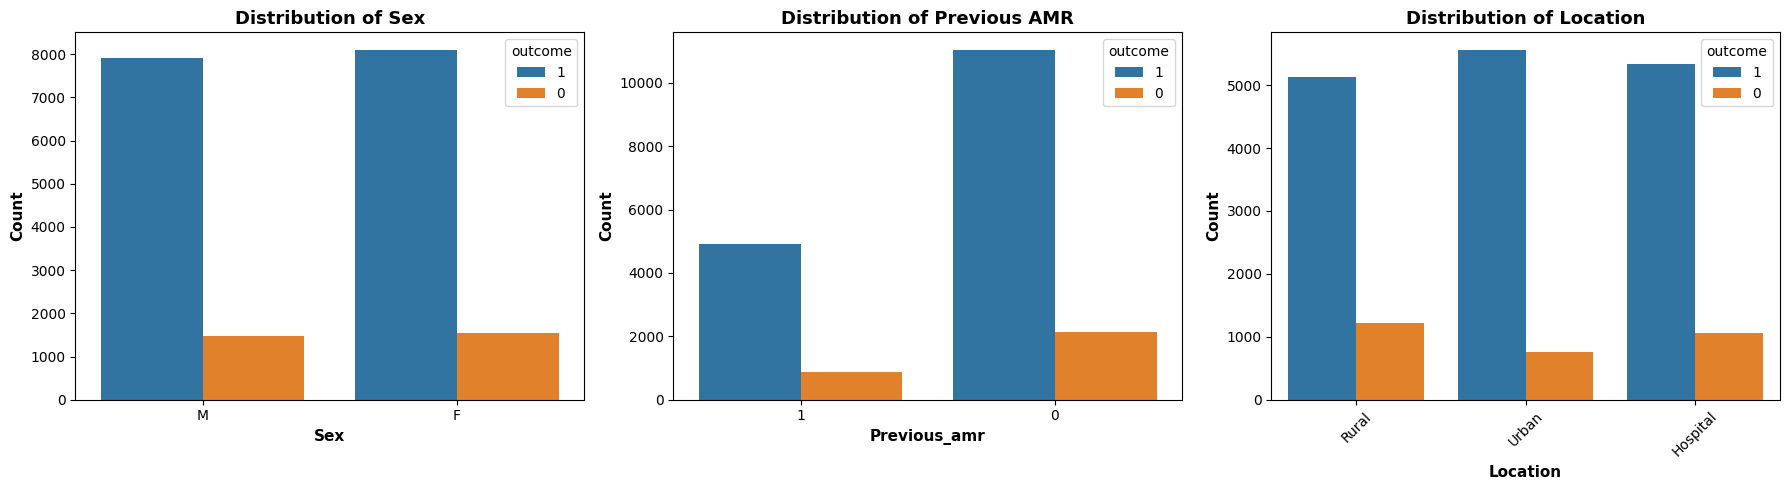

In [9]:
# Create a 1x3 subplot for categorical variable distributions
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Plot 1: Sex Distribution
sns.countplot(data=df_categorical_copy, x='sex', hue='outcome', ax=axes[0])
axes[0].set_title('Distribution of Sex', fontsize=13, fontweight='bold')
axes[0].set_xlabel('Sex', fontsize=11, fontweight='bold')
axes[0].set_ylabel('Count', fontsize=11, fontweight='bold')

# Plot 2: AMR Distribution
sns.countplot(data=df_categorical_copy, x='previous_amr', hue='outcome', ax=axes[1])
axes[1].set_title('Distribution of Previous AMR', fontsize=13, fontweight='bold')
axes[1].set_xlabel('Previous_amr', fontsize=11, fontweight='bold')
axes[1].set_ylabel('Count', fontsize=11, fontweight='bold')

# Plot 3: Location Distribution
sns.countplot(data=df_categorical_copy, x='location',  hue='outcome', ax=axes[2])
axes[2].set_title('Distribution of Location', fontsize=13, fontweight='bold')
axes[2].set_xlabel('Location', fontsize=11, fontweight='bold')
axes[2].set_ylabel('Count', fontsize=11, fontweight='bold')
axes[2].tick_params(axis='x', rotation=45)

# Adjust layout
plt.tight_layout()
plt.show()

# **Mann–Whitney U Test for Continuous Variables by Outcome**

In [10]:

# Create a copy of the DataFrame to avoid modifying the original data
df_stat_p = df.copy()

# Ensure 'df_stat' is numeric
df_stat_p = df_stat_p.apply(pd.to_numeric, errors='coerce')
df_stat_p = df_stat_p.drop(columns=['sex', 'previous_amr', 'location'])

# Separate groups by outcome
group0 = df_stat_p[df_stat_p['outcome'] == 0]
group1 = df_stat_p[df_stat_p['outcome'] == 1]

# Compute Mann–Whitney U test results for each numeric column (excluding outcome)
mw_stats = pd.DataFrame({
    'U_stat': [
        mannwhitneyu(group0[c].dropna(), group1[c].dropna(), alternative='two-sided')[0]
        for c in group0.columns if c != 'outcome'
    ],
    'p_value': [
        mannwhitneyu(group0[c].dropna(), group1[c].dropna(), alternative='two-sided')[1]
        for c in group0.columns if c != 'outcome'
    ]
}, index=[c for c in group0.columns if c != 'outcome'])


# Format p-values
mw_stats['p_value'] = mw_stats['p_value'].apply(lambda x: '<0.001' if x < 0.001 else round(x, 3))

# Display the final table
print(mw_stats)

                                  U_stat p_value
days_in_hospital              17410574.0  <0.001
age                           23646140.0   0.037
days_of_previous_antibiotics  21743899.5  <0.001
last_blood_test               27082248.0  <0.001
temperature                   25190614.0  <0.001
heart_rate                     2246351.5  <0.001
resp_rate                     24334334.0   0.557
sbp                           17599998.5  <0.001


# **Interactive 3D plot visualizing feature relationship with outcome (Features choice - days in hospital, heart rate and Sbp)**

In [11]:
df_3dplot = df.copy()
df_3dplot['days_in_hospital'] = pd.to_numeric(df_3dplot['days_in_hospital'], errors='coerce')
df_3dplot['heart_rate'] = pd.to_numeric(df_3dplot['heart_rate'], errors='coerce')
df_3dplot['sbp'] = pd.to_numeric(df_3dplot['sbp'], errors='coerce')

# For D Scatter Plot
fig = plt.figure(figsize=(10, 8))

# Interactive 3D scatter plot
fig = px.scatter_3d(
    df_3dplot,
    x='days_in_hospital', y='heart_rate', z='sbp',
    color='outcome',
    color_continuous_scale='RdBu',
    symbol='outcome',
    opacity=1,
    title='3D Scatter: Days in Hospital, Heart Rate, SBP vs Outcome'
)

# Make interactive
fig.update_traces(marker=dict(size=2, line=dict(width=1, color='DarkSlateGrey')))

# Update axes, title, and legend fonts for presentation quality
fig.update_layout(
    scene=dict(
        xaxis=dict(
            title='Days in Hospital',
            titlefont=dict(size=18, family='Arial, bold'),
            tickfont=dict(size=14, family='Arial, bold')
        ),
        yaxis=dict(
            title='Heart Rate',
            titlefont=dict(size=18, family='Arial, bold'),
            tickfont=dict(size=14, family='Arial, bold')
        ),
        zaxis=dict(
            title='SBP',
            titlefont=dict(size=18, family='Arial, bold'),
            tickfont=dict(size=14, family='Arial, bold')
        ),
    ),
    legend=dict(
        title='Outcome',        # Legend title
        title_font=dict(size=18),  # Title font size
        font=dict(size=16),        # Legend label font size
        itemsizing='constant',     # Keeps marker size consistent
        bgcolor='rgba(255,255,255,0.5)',  # Optional: semi-transparent background
    ),
    title_font=dict(size=20, family='Arial, bold'),
    margin=dict(l=0, r=0, b=0, t=50)
)

fig.show()




<Figure size 1000x800 with 0 Axes>

# **Chi-Square Test Results: Sex, Previous AMR, and Location vs Outcome**

In [12]:
# Sex vs Outcome
table_sex = pd.crosstab(df_categorical_copy['sex'], df_categorical_copy['outcome'])
chi2_sex, p_sex, _, _ = chi2_contingency(table_sex)
p_sex_text = "<0.001" if p_sex < 0.001 else f"{p_sex:.4f}"

# Previous AMR vs Outcome
table_amr = pd.crosstab(df_categorical_copy['previous_amr'], df_categorical_copy['outcome'])
chi2_amr, p_amr, _, _ = chi2_contingency(table_amr)
p_amr_text = "<0.001" if p_amr < 0.001 else f"{p_amr:.4f}"

# Location vs Outcome
table_loc = pd.crosstab(df_categorical_copy['location'], df_categorical_copy['outcome'])
chi2_loc, p_loc, _, _ = chi2_contingency(table_loc)
p_loc_text = "<0.001" if p_loc < 0.001 else f"{p_loc:.4f}"

# Create DataFrame for results
chi2_results = pd.DataFrame({
    'Variable': ['sex', 'previous_amr', 'location'],
    'Chi2': [round(chi2_sex, 3), round(chi2_amr, 3), round(chi2_loc, 3)],
    'p_value': [p_sex_text, p_amr_text, p_loc_text]
})

print("Chi-square Test Results for Categorical Variables vs Outcome:")
display(chi2_results)

Chi-square Test Results for Categorical Variables vs Outcome:


,Variable,Chi2,p_value
0,sex,0.229,0.6320
1,previous_amr,4.253,0.0392
2,location,121.969,<0.001


In [13]:
df_clean['outcome'].value_counts()

,count
outcome,
1,9610
0,1769


# **Apply PCA for feature visualization examing class seperability**

In [14]:
# Create a copy of the cleaned DataFrame to avoid modifying the original data
df_clean_PCA = df_clean.copy()

# Separate features and outcome
Data_X = df_clean_PCA.drop(columns=['outcome'])
Data_y = df_clean_PCA['outcome']

# Standardize the data
scaler = StandardScaler()
Data_X_scaled = scaler.fit_transform(Data_X)

# Apply PCA to reduce to 3 components
pca = PCA(n_components=3)
Data_X_PCA = pca.fit_transform(Data_X_scaled)

# Create a DataFrame for the PCA components
pca_df = pd.DataFrame(data=Data_X_PCA, columns=['PC1', 'PC2', 'PC3'])
pca_df['outcome'] = Data_y.values

# 3D Scatter Plot
fig = plt.figure(figsize=(10, 8))

# Interactive 3D scatter plot
fig = px.scatter_3d(
    pca_df,
    x='PC1', y='PC2', z='PC3',
    color='outcome',
    color_continuous_scale='RdBu',
    symbol='outcome',
    opacity=1
)

# Make the layout cleaner
fig.update_traces(marker=dict(size=2))
fig.update_layout(
    scene=dict(
        xaxis_title='Principal Component 1',
        yaxis_title='Principal Component 2',
        zaxis_title='Principal Component 3'
    ),
    title_font=dict(size=18, color='black', family='Arial'),
)

fig.show()


<Figure size 1000x800 with 0 Axes>

## **Apply UMAP for feature visualization examing class seperability**

In [15]:
# Create a copy of the cleaned DataFrame to avoid modifying the original data
df_clean_UMAP = df_clean.copy()

# Separate features and outcome
Data_X = df_clean_UMAP.drop(columns=['outcome'])
Data_y = df_clean_UMAP['outcome']

# Standardize the data
scaler = StandardScaler()
Data_X_scaled = scaler.fit_transform(Data_X)

# Apply UMAP in 3D
umap_model = umap.UMAP(
    n_components=3,
    n_neighbors=50,
    min_dist=0.5,
    metric='cosine',
    random_state=42
)
X_umap = umap_model.fit_transform(Data_X_scaled)


# Create DataFrame for visualization
UMAP_df = pd.DataFrame(X_umap, columns=['UMAP1', 'UMAP2', 'UMAP3'])
UMAP_df['outcome'] = Data_y.values


# 3D Scatter Plot
fig = plt.figure(figsize=(10, 8))

# Interactive 3D scatter plot
fig = px.scatter_3d(
    UMAP_df,
    x='UMAP1', y='UMAP2', z='UMAP3',
    color='outcome',
    color_continuous_scale='RdBu',
    symbol='outcome',
    opacity=0.8
)

# Reduce marker size
fig.update_traces(marker=dict(size=2))

# Improve layout
fig.update_layout(
    scene=dict(
        xaxis_title='UMAP Dimension 1',
        yaxis_title='UMAP Dimension 2',
        zaxis_title='UMAP Dimension 3'
    ),
    title_font=dict(size=18, color='black', family='Arial'),
)

fig.show()

/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



<Figure size 1000x800 with 0 Axes>

## **Apply t-SNE for feature visualization examing class seperability**





In [16]:
df_sample = df_clean.sample(n=5000, random_state=42)

# Create a copy of the cleaned DataFrame to avoid modifying the original data
df_clean_TSNE = df_sample.copy()

# Separate features and outcome
Data_X = df_clean_TSNE.drop(columns=['outcome'])
Data_y = df_clean_TSNE['outcome']

# Standardize the data
scaler = StandardScaler()
Data_X_scaled = scaler.fit_transform(Data_X)


# Apply t-SNE (3D)
tsne = TSNE(n_components=3, perplexity=30, learning_rate=200, random_state=42)
X_tsne = tsne.fit_transform(Data_X_scaled)

# Create DataFrame for visualization
TSNE_df = pd.DataFrame(X_tsne, columns=['Dim1', 'Dim2', 'Dim3'])
TSNE_df['outcome'] = Data_y.values


# 3D Scatter Plot
fig = plt.figure(figsize=(10, 8))

# Interactive 3D scatter plot
fig = px.scatter_3d(
    TSNE_df,
    x='Dim1', y='Dim2', z='Dim3',
    color='outcome',
    color_continuous_scale='RdBu',
    symbol='outcome',
    opacity=0.8
)


# Reduce marker size
fig.update_traces(marker=dict(size=2))

# Improve layout
fig.update_layout(
    scene=dict(
        xaxis_title='t-SNE Dimension 1',
        yaxis_title='t-SNE Dimension 2',
        zaxis_title='t-SNE Dimension 3'
    ),
    title_font=dict(size=18, color='black', family='Arial'),
)

fig.show()

<Figure size 1000x800 with 0 Axes>

## **Optimize XGBoost hyperparameters using randomized search with stratified cross-validation.**

In [17]:
# Create a copy of the cleaned DataFrame to avoid modifying the original data
df_Model = df.copy()

# Ensure values in 'df_Model' is numeric; non-numeric values are converted to NaN
df_Model = df_Model.apply(pd.to_numeric, errors='coerce')


# Separate features and outcome
X = df_Model.drop(columns=['outcome'])
y = df_Model['outcome']

# Split data into training and testing sets (80/20)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Model Initialization
# Initialize an XGBoost classifier for binary classification
xgb = XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    use_label_encoder=False,
    random_state=42,
    verbose=1  # shows boosting round progres
)

# Parameter search space for RandomizedSearchCV; for every key values define sampling distributions
param_grid = {
    'n_estimators': randint(200, 600),        # broader, continuous-like sampling
    'max_depth': randint(3, 8),               # smaller trees to moderate depth
    'learning_rate': uniform(0.01, 0.09),     # samples in [0.01, 0.1]
    'subsample': uniform(0.6, 0.4),           # samples in [0.6, 1.0]
    'colsample_bytree': uniform(0.6, 0.4),    # samples in [0.6, 1.0]
    'gamma': uniform(0, 0.4),                 # samples in [0, 0.4]
    'min_child_weight': randint(1, 6),         # discrete 1–5 range
    'reg_alpha': uniform(0, 0.5),             # L1 penalty term (sparse features)
    'reg_lambda': uniform(0.5, 2.0),          # L2 penalty term (smooth weights)
    'scale_pos_weight': uniform(0.5, 10.0)     # adjust if class imbalance exists
}

# Use StratifiedKFold to preserve class distribution across folds
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Randomized search over the hyperparameter space
random_search = RandomizedSearchCV(
    estimator=xgb,
    param_distributions=param_grid,
    n_iter=20,  # test 50 random combinations (you control this!)
    scoring='balanced_accuracy',
    cv=cv,
    n_jobs=-1,
    verbose=2,
    random_state=42
)

# Fit the model to the training data while performing randomized search
random_search.fit(X_train, y_train)

# Best parameter combination of hyperparameters and corresponding cross-validation balanced-accuracy
print("Best Parameters:", random_search.best_params_)
print("Best CV Accuracy:", random_search.best_score_)

# Store the cross-validation result and subsequently sorting it
results = pd.DataFrame(random_search.cv_results_)
results = results.sort_values(by='mean_test_score', ascending=False)



Fitting 5 folds for each of 20 candidates, totalling 100 fits


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning:

[19:39:21] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder", "verbose" } are not used.




Best Parameters: {'colsample_bytree': np.float64(0.7103996728090174), 'gamma': np.float64(0.11850940228163297), 'learning_rate': np.float64(0.024874024515670223), 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 543, 'reg_alpha': np.float64(0.19744075908778486), 'reg_lambda': np.float64(1.0869763494360762), 'scale_pos_weight': np.float64(0.6407982271508446), 'subsample': np.float64(0.679536961635522)}
Best CV Accuracy: 0.9149755169100494


## **Evaluate the optimized model on test data with confusion matrix, classification report, and balanced accuracy.**

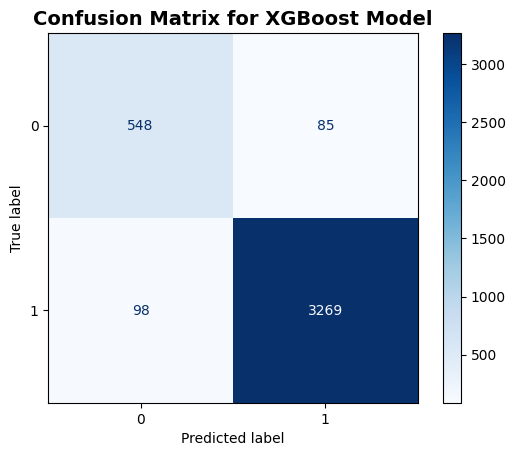

              precision    recall  f1-score   support

           0       0.85      0.87      0.86       633
           1       0.97      0.97      0.97      3367

    accuracy                           0.95      4000
   macro avg       0.91      0.92      0.91      4000
weighted avg       0.95      0.95      0.95      4000

Balanced Accuracy: 0.9183


In [21]:
# Stratified split of data into training and testing ensuring
#both sets maintain the same class distribution as the original dataset
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Retrieve the best hyperparameters obtained from the RandomizedSearchCV
best_params = random_search.best_params_

# Initialize the final XGBoost model using the optimized parameters
final_model = XGBClassifier(
    **best_params,
    objective='binary:logistic',
    eval_metric='logloss',
    random_state=42
)

#Fit the final model on the training data
final_model.fit(X_train, y_train)

# Predict the unseen test data
y_pred = final_model.predict(X_test)

# Confusion Matrix evaluating the performance
cm = confusion_matrix(y_test, y_pred)

# Visualize the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues', values_format='d')
plt.title('Confusion Matrix for XGBoost Model', fontsize=14, fontweight='bold')
plt.show()

# Detailed classification report
report = classification_report(y_test, y_pred, target_names=['0', '1'])
print(report)

# Calculate the balanced accuracy — accounts for class imbalance by averaging recall per class
bal_acc = balanced_accuracy_score(y_test, y_pred)
print(f"Balanced Accuracy: {bal_acc:.4f}")

# **Estimate model performance using repeated stratified cross-validation with 95% confidence interval.**

In [22]:
# 5-fold CV repeated 10 times for robust performance estimation - 80/20 Train-Test
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=10, random_state=42)

# Compute balanced accuracy scores across folds
scores = cross_val_score(final_model, X, y, cv=cv, scoring='balanced_accuracy')

# Calculate mean, standard deviation, and 95% confidence interval
mean_accuracy = np.mean(scores)
std_accuracy = np.std(scores)
ci_lower = mean_accuracy - 1.96 * std_accuracy / np.sqrt(len(scores))
ci_upper = mean_accuracy + 1.96 * std_accuracy / np.sqrt(len(scores))

print(f"BALANCED ACCURACY: {mean_accuracy:.3f} ± {std_accuracy:.3f}")
print(f"95% CI: [{ci_lower:.3f}, {ci_upper:.3f}]")

BALANCED ACCURACY: 0.915 ± 0.006
95% CI: [0.913, 0.916]


## **Plot of balanced accuracy scores with mean and 95% confidence interval**

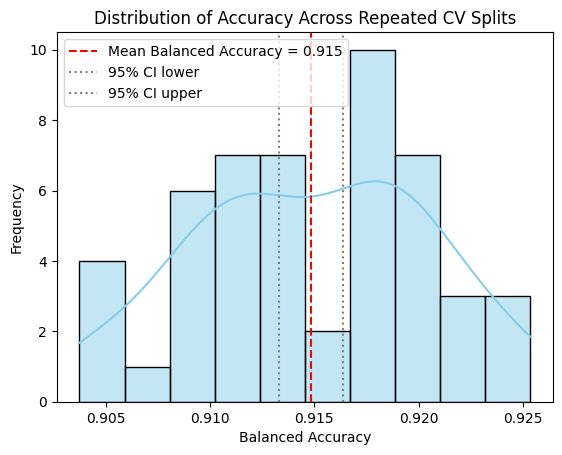

In [23]:
# Histogram with KDE curve showing score distribution
sns.histplot(scores, kde=True, bins=10, color='skyblue')

# Add vertical lines for mean and 95% confidence interval
plt.axvline(mean_accuracy, color='red', linestyle='--', label=f"Mean Balanced Accuracy = {mean_accuracy:.3f}")
plt.axvline(ci_lower, color='gray', linestyle=':', label='95% CI lower')
plt.axvline(ci_upper, color='gray', linestyle=':', label='95% CI upper')
plt.legend()
plt.title("Distribution of Accuracy Across Repeated CV Splits")
plt.xlabel("Balanced Accuracy")
plt.ylabel("Frequency")
plt.show()

## **To understand which variables most strongly influence the XGBoost predictions, top 10 features ranked by gain-based importance was visualized.**

<Figure size 1000x800 with 0 Axes>

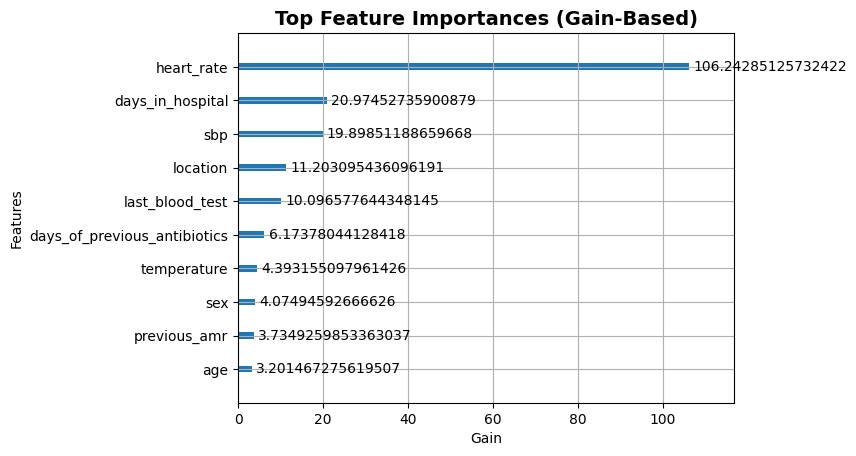

In [24]:
plt.figure(figsize=(10, 8))

# Plot top 10 most important features based on gain from the trained XGBoost model
plot_importance(final_model, importance_type='gain', max_num_features=10)
plt.title("Top Feature Importances (Gain-Based)", fontsize=14, fontweight='bold')
plt.xlabel("Gain")
plt.ylabel("Features")
plt.show()

# **To interpret model predictions, SHAP summary plot was generated on 10% of test data to highlight the most influential features.**

PermutationExplainer explainer: 401it [03:06,  2.10it/s]
/tmp/ipython-input-754781511.py:15: FutureWarning:

The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.



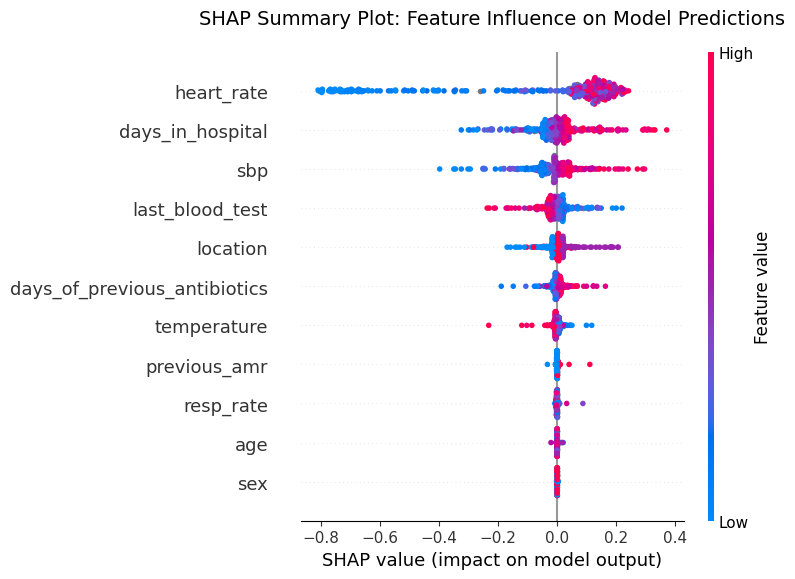

In [32]:
shap.initjs()

# Sample a subset (10%) of test data for faster SHAP computation and plotting
sample_data = X_test.sample(400, random_state=42)

# Create a SHAP explainer using the model's prediction function and sampled data
explainer = shap.Explainer(final_model.predict, sample_data)

# Compute SHAP values for the sampled data
shap_values = explainer(sample_data)

plt.title("SHAP Summary Plot: Feature Influence on Model Predictions", fontsize=14, pad=20)

# Generate SHAP summary plot to visualize feature impact and importance
shap.summary_plot(shap_values)



# **Interactive 3D plot visualizing feature relationship with outcome (Features choice - days in hospital, heart rate and Sbp) for misclassified points**

In [26]:
# find misclassified samples
y_pred = final_model.predict(X_test)
misclassified_3d = X_test.copy()

#Add true label and predicted label
misclassified_3d['true_label'] = y_test
misclassified_3d['pred_label'] = y_pred

# Keep only the rows where predictions do not match the true labels (misclassifications)
misclassified_3d = misclassified_3d[misclassified_3d['true_label'] != misclassified_3d['pred_label']]

# Convert true labels to string type
misclassified_3d['true_label'] = misclassified_3d['true_label'].astype(str)


# 3D scatter plot with red and blue markers
fig = px.scatter_3d(
    misclassified_3d,
    x='days_in_hospital',
    y='heart_rate',
    z='sbp',
    color='true_label',  # color by true label
    color_continuous_scale='RdBu',
    symbol='true_label',
    opacity=1,
    title='3D Scatter: misclassified_ Cases by True Outcome'
)

# Adjust marker size and Label the 3D axes
fig.update_traces(marker=dict(size=6))
fig.update_layout(scene=dict(
    xaxis_title='Days in Hospital',
    yaxis_title='Heart Rate',
    zaxis_title='SBP'
))

fig.show()

# **SHAP summary plot visualizing feature importance and directional influence for misclassified points.**

PermutationExplainer explainer: 184it [01:47,  1.67it/s]
/tmp/ipython-input-3384872614.py:22: FutureWarning:

The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.



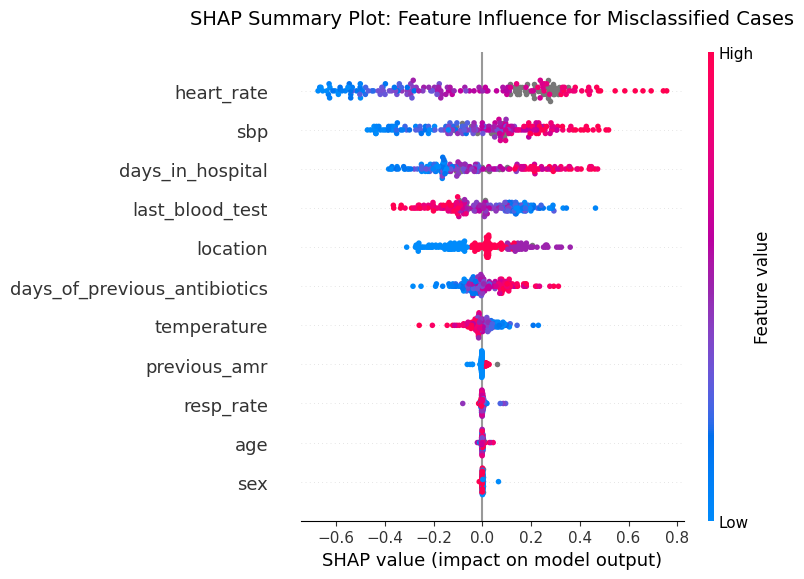

In [31]:

# find misclassified samples
misclassified_Shap = X_test.copy()

#Add true label and predicted label
misclassified_Shap['true_label'] = y_test
misclassified_Shap['pred_label'] = y_pred

# Keep only the rows where predictions do not match the true labels (misclassifications)
misclassified_Shap = misclassified_Shap[misclassified_Shap['true_label'] != misclassified_Shap['pred_label']]

#Drop true label and predicted label
misclassified_Shap = misclassified_Shap.drop(columns=['true_label','pred_label'])

# Create a SHAP explainer using the model's prediction function on misclassified data
explainer = shap.Explainer(final_model.predict, misclassified_Shap)

# Compute SHAP values for the sampled data
shap_values_misclassified = explainer(misclassified_Shap)

plt.title("SHAP Summary Plot: Feature Influence for Misclassified Cases", fontsize=14, pad=20)
# Generate SHAP summary plot to visualize feature impact and importance
shap.summary_plot(shap_values_misclassified)

